In [37]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import tifffile
import os

In [100]:
def find_nanowell(BF_img,opening):
    # area range of a square/nanowell 
    min_area = 1.0
    max_area = 1000000.0
    # final segmented nanowell size: nanowell_size=height=width
    nanowell_size=160
    # adjust coordinates of identified nanowells
    offset_x=-10
    offset_y=-10
    # find all nanowells in a restricted region
    xMin,xMax=200,6500
    yMin,yMax=200,6500

    # get all contours. Only the outer contours will be returned. 
    cnts = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    image_number = 0 # nanowell counts

    fig, ax = plt.subplots(figsize=(10, 10))
    centroidsBF=[]
    half_size = nanowell_size // 2
    for c in cnts:
        area = cv2.contourArea(c)
        if area > min_area and area < max_area:
            # compute the center of the contour
            M = cv2.moments(c)
            x = int(M["m10"] / M["m00"])+offset_x
            y = int(M["m01"] / M["m00"])+offset_y
            if xMin<x<xMax and yMin<y<yMax:
                centroidsBF.append((x,y))
                # visulaize segmented nanowells
                square = plt.Rectangle((x - half_size, y - half_size), nanowell_size, nanowell_size, 
                                    fill=False, edgecolor='red',linewidth=0.5)
                image_number+=1
                ax.add_patch(square)

    ax.imshow(BF_img,cmap='gray')
    print('total=',image_number)
    plt.show()
    return centroidsBF

def crop_squares(image, centroids, square_size, save_path):
    
    for i in range(len(centroids)):
        x, y = centroids[i]
        
        # Calculate the top-left corner of the square
        top_left_x = int(x - square_size / 2)
        top_left_y = int(y - square_size / 2)
        
        # Crop the square
        square = image[top_left_y:top_left_y+square_size, top_left_x:top_left_x+square_size]

        square_save=save_path+'_'+str(i)+'.jpg'
        cv2.imwrite(square_save,square)   

File path: F:\01_GSIS_nanowell\test_data\WellC18_ChannelBF_20XELWD,DAPI_20XELWD,EGFP_20XELWD,CY5_20XELWD,CY3_20XELWD_Seq0000.tif


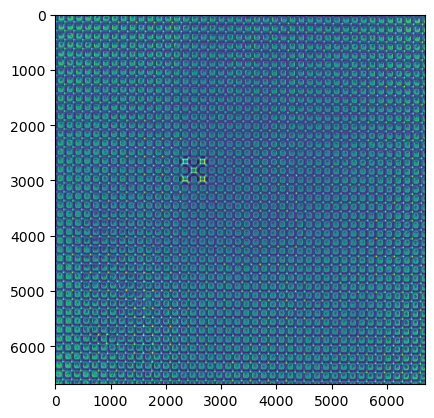

In [132]:
save_path='F:\01_GSIS_nanowell\test_data\output' # save segmented nanowells

# load an image
OME_directory=r'F:\01_GSIS_nanowell\test_data'
OME_base_name = 'WellC18_ChannelBF_20XELWD,DAPI_20XELWD,EGFP_20XELWD,CY5_20XELWD,CY3_20XELWD_Seq0000.tif'
filename_OME= os.path.join(OME_directory, OME_base_name)
print("File path:", filename_OME)
img1_BF = tifffile.imread(filename_OME, key=0)
#img=cv2.imread(img1_BF)
BF_img = cv2.normalize(img1_BF, None, 240, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
plt.imshow(BF_img)
#BF_img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  


total= 1424


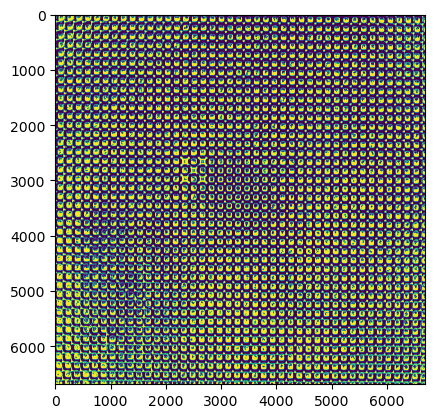

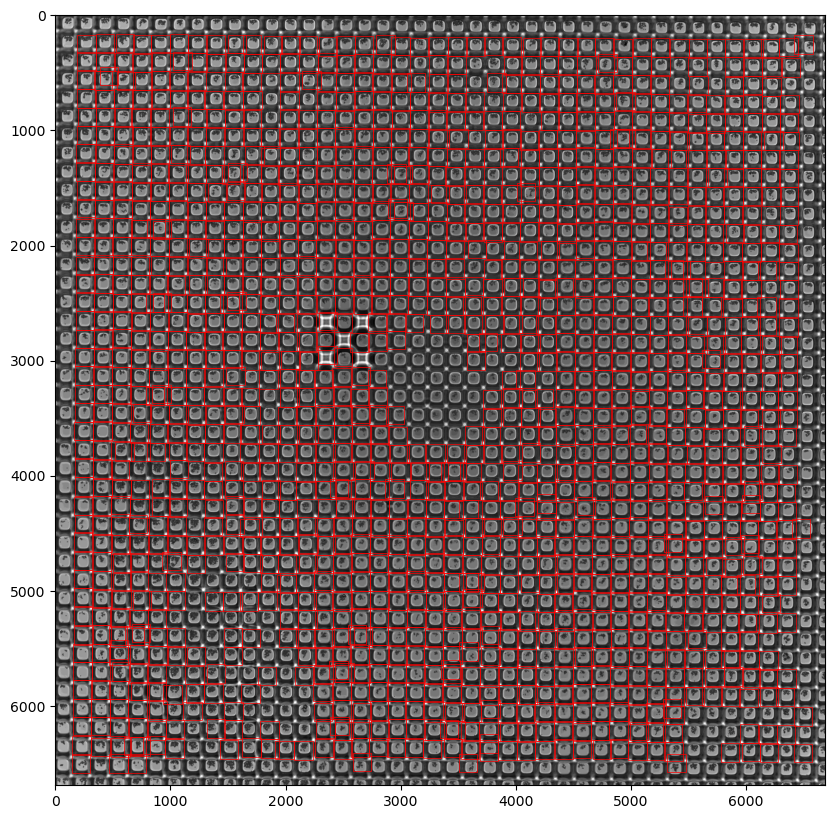

In [133]:

### image preprocessing-------------------------------------------------------------------
ret, threshold = cv2.threshold(BF_img.copy(), 0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Creates a 4x4 rectangular structuring element for morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4,4))
# close small holes inside the foreground objects or small black points on the object.
close = cv2.morphologyEx(threshold, cv2.MORPH_CLOSE, kernel, iterations=2)
kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (40,40))
# remove small objects (it's good for removing noise)
opening = cv2.morphologyEx(close, cv2.MORPH_OPEN, kernel2)
plt.imshow(threshold)

centroidsBF=find_nanowell(BF_img,opening)
#crop_squares(BF_img, centroidsBF, 248, save_path )
